<a href="https://colab.research.google.com/github/BatoolMM/fastai/blob/master/Chapter_4_Under_the_Hood_Training_a_Digit_Classifier_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Chapter 4. Under the Hood: Training a Digit Classifier**

In [1]:
!pip install -Uqq fastbook
!pip install fastcore
!pip install fastai
!pip install utils

     |████████████████████████████████| 727kB 4.6MB/s 
     |████████████████████████████████| 194kB 13.4MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
     |████████████████████████████████| 1.0MB 14.9MB/s 
     |████████████████████████████████| 51kB 7.9MB/s 
     |████████████████████████████████| 51kB 7.5MB/s 
     |████████████████████████████████| 92kB 9.9MB/s 
     |████████████████████████████████| 40kB 6.9MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
     |████████████████████████████████| 61kB 9.5MB/s 
     |████████████████████████████████| 2.6MB 19.9MB/s 


In [2]:
from utils import *
from fastai.vision.all import *
from fastai.vision.widgets import ImageClassifierCleaner

In [3]:
?download_images

In [4]:
path = untar_data(URLs.MNIST_SAMPLE)

In [5]:
path.ls()

(#3) [Path('/root/.fastai/data/mnist_sample/valid'),Path('/root/.fastai/data/mnist_sample/train'),Path('/root/.fastai/data/mnist_sample/labels.csv')]

In [6]:
(path/'train'/'7').ls()

(#6265) [Path('/root/.fastai/data/mnist_sample/train/7/33681.png'),Path('/root/.fastai/data/mnist_sample/train/7/40214.png'),Path('/root/.fastai/data/mnist_sample/train/7/3788.png'),Path('/root/.fastai/data/mnist_sample/train/7/42544.png'),Path('/root/.fastai/data/mnist_sample/train/7/47325.png'),Path('/root/.fastai/data/mnist_sample/train/7/6147.png'),Path('/root/.fastai/data/mnist_sample/train/7/617.png'),Path('/root/.fastai/data/mnist_sample/train/7/51138.png'),Path('/root/.fastai/data/mnist_sample/train/7/56567.png'),Path('/root/.fastai/data/mnist_sample/train/7/37835.png')...]

In [7]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('/root/.fastai/data/mnist_sample/train/3/10.png'),Path('/root/.fastai/data/mnist_sample/train/3/10000.png'),Path('/root/.fastai/data/mnist_sample/train/3/10011.png'),Path('/root/.fastai/data/mnist_sample/train/3/10031.png'),Path('/root/.fastai/data/mnist_sample/train/3/10034.png'),Path('/root/.fastai/data/mnist_sample/train/3/10042.png'),Path('/root/.fastai/data/mnist_sample/train/3/10052.png'),Path('/root/.fastai/data/mnist_sample/train/3/1007.png'),Path('/root/.fastai/data/mnist_sample/train/3/10074.png'),Path('/root/.fastai/data/mnist_sample/train/3/10091.png')...]

In [8]:
tensor_threes = [tensor(Image.open(i)) for i in threes]
tensor_sevens = [tensor(Image.open(i)) for i in sevens]
tensor_threes[1][4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

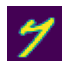

In [9]:
show_image(tensor_sevens[1])

In [10]:
stacked_threes = torch.stack(tensor_threes).float()/255
stacked_sevens = torch.stack(tensor_sevens).float()/255

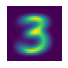

In [11]:
show_image(stacked_threes.mean(0))

In [12]:
abs_three_tomeanthree = (stacked_threes.mean(0) - stacked_threes[1]).abs().mean()
rmse_three_tomeanthree = ((stacked_threes.mean(0) - stacked_threes[1])**2).mean().sqrt()
abs_three_tomeanthree, rmse_three_tomeanthree

(tensor(0.1114), tensor(0.2021))

In [13]:
abs_three_tomeanseven = (stacked_sevens.mean(0) - stacked_threes[1]).abs().mean()
rmse_three_tomeanseven = ((stacked_sevens.mean(0) - stacked_threes[1])**2).mean().sqrt()
abs_three_tomeanseven, rmse_three_tomeanseven

(tensor(0.1586), tensor(0.3021))

In [14]:
#in pytorch

abs_three_tomeanseven = F.l1_loss(stacked_sevens.mean(0), stacked_threes[1])
rmse_three_tomeanseven = F.mse_loss(stacked_sevens.mean(0) , stacked_threes[1]).sqrt()
abs_three_tomeanseven, rmse_three_tomeanseven

(tensor(0.1586), tensor(0.3021))

## **Validation set**

In [15]:
(path/'valid').ls()

(#2) [Path('/root/.fastai/data/mnist_sample/valid/7'),Path('/root/.fastai/data/mnist_sample/valid/3')]

In [16]:
valid_three = torch.stack([tensor(Image.open(i)) for i in (path/'valid'/'3').ls()])
valid_three = valid_three.float()/255
valid_seven = torch.stack([tensor(Image.open(i)) for i in (path/'valid'/'7').ls()])
valid_seven = valid_seven.float()/225
valid_three.shape,valid_seven.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [17]:
mean_seven = stacked_sevens.mean(0)
mean_three = stacked_threes.mean(0)
#without broadcasting
(valid_seven - mean_three).abs().mean(), (valid_seven - mean_three).abs().mean().shape

#with broadcasting
(valid_seven - mean_three).abs().mean((-1,-2)), (valid_seven - mean_three).abs().mean((-1,-2)).shape

(tensor([0.1634, 0.1872, 0.1801,  ..., 0.1995, 0.1434, 0.1712]),
 torch.Size([1028]))

In [18]:
def mnist_l1_loss(a, b):
  return (a - b).abs().mean((-1, -2))

mnist_l1_loss(valid_seven, mean_three,), mnist_l1_loss(valid_seven, mean_three).shape

(tensor([0.1634, 0.1872, 0.1801,  ..., 0.1995, 0.1434, 0.1712]),
 torch.Size([1028]))

In [19]:
def is_three(x):
  mean_seven = stacked_sevens.mean(0)
  mean_three = stacked_threes.mean(0)
  return mnist_l1_loss(x, mean_three) < mnist_l1_loss(x, mean_seven)

is_three(valid_three), is_three(valid_three).float()

(tensor([True, True, True,  ..., True, True, True]),
 tensor([1., 1., 1.,  ..., 1., 1., 1.]))

In [20]:
accuracy_3 = is_three(valid_three).float().mean()
accuracy_7 = (1 - is_three(valid_seven).float()).mean()
accuracy_3, accuracy_7

(tensor(0.9168), tensor(0.9864))

## **Gradient descent**

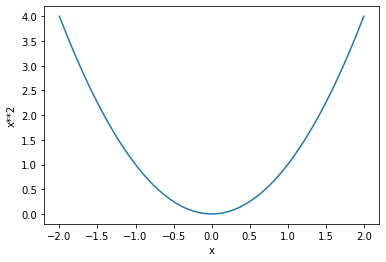

In [21]:
def f(x):
  return x**2

def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
    x = torch.linspace(min,max)
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(x,f(x))
    if tx is not None: ax.set_xlabel(tx)
    if ty is not None: ax.set_ylabel(ty)
    if title is not None: ax.set_title(title)

plot_function(f,'x', 'x**2')

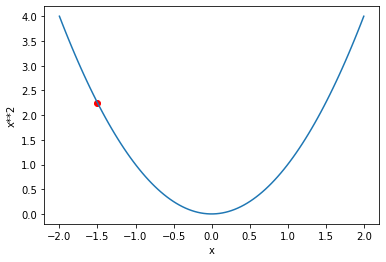

In [22]:
plot_function(f,'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red')

In [23]:
def f(x):
  return x**2

In [24]:
der_x_3 = tensor(3.).requires_grad_()
der_x_3

tensor(3., requires_grad=True)

In [25]:
der_f = f(der_x_3)
der_f

tensor(9., grad_fn=<PowBackward0>)

In [26]:
der_f.backward()
der_x_3.grad

tensor(6.)

## **Roller coaster**

In [27]:
time = torch.arange(20.)
time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19.])

In [28]:
#original speed
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
speed

tensor([71.5652, 49.4377, 38.4897, 33.4548, 29.7308, 18.9246, 11.1622,  8.0513,
         2.4024, -0.1592,  1.6864,  1.1261,  6.1391,  7.6554, 13.5359, 23.2908,
        34.0356, 42.7079, 53.5426, 69.2375])

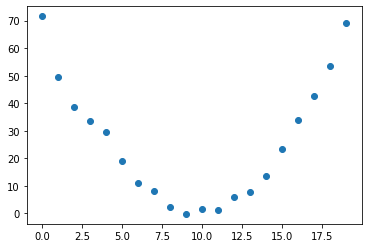

In [29]:
plt.scatter(time, speed)

In [30]:
#the equation
def f(t, params):
  a,b,c = params
  return a*(t**2) + (b*t) + c

In [31]:
#initi the weights
params = torch.randn(3).requires_grad_()
params

tensor([ 1.4671, -0.4666, -1.2547], requires_grad=True)

In [32]:
#define loss function
def mse(preds, targets):
  return ((targets - preds)**2).mean()

In [33]:
#check the weights with function and lose function
preds = f(time, params)
preds

tensor([-1.2547e+00, -2.5421e-01,  3.6805e+00,  1.0549e+01,  2.0352e+01,
         3.3090e+01,  4.8761e+01,  6.7367e+01,  8.8907e+01,  1.1338e+02,
         1.4079e+02,  1.7113e+02,  2.0441e+02,  2.4062e+02,  2.7976e+02,
         3.2184e+02,  3.6686e+02,  4.1480e+02,  4.6568e+02,  5.1950e+02],
       grad_fn=<AddBackward0>)

In [34]:
loss = mse(preds, speed)
loss 

tensor(47938.4023, grad_fn=<MeanBackward0>)

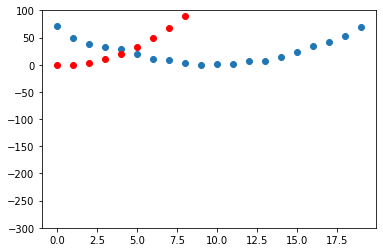

In [35]:
def show_pred(preds, plot=None):
  if plot is None:
    plot = plt.subplots()[1]
    plot.scatter(time, speed)
    plot.scatter(time, to_np(preds), color ='red')
    plot.set_ylim(-300, 100)

show_pred(preds)

In [36]:
loss.backward()
params.grad

tensor([72937.5234,  4669.8540,   299.3956])

In [37]:
 lr = 1e-5
params.data -= lr *params.grad.data
params.grad = None

In [38]:
preds = f(time, params)
mse(preds, speed)

tensor(9610.9668, grad_fn=<MeanBackward0>)

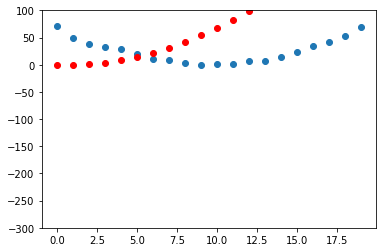

In [39]:
show_pred(preds)

In [40]:
params

tensor([ 0.7377, -0.5133, -1.2577], requires_grad=True)

In [41]:
params.data

tensor([ 0.7377, -0.5133, -1.2577])

In [42]:
def apply_steps(params, prt=True):
  preds = f(time, params)
  loss = mse(preds, speed)
  loss.backward()
  lr = 1e-5
  params.data -= lr * params.grad.data
  params.grad = None
  if prt:
    print(loss.item())
  return preds

In [43]:
for i in range(10):
  apply_steps(params)

9610.966796875
2358.242431640625
985.8006591796875
726.0885009765625
676.9382934570312
667.633056640625
665.8674926757812
665.5289916992188
665.4603271484375
665.44287109375


## **The MNIST Loss Function**

In [44]:
# make the training into vector
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_x.shape, stacked_threes.shape, stacked_sevens.shape

(torch.Size([12396, 784]),
 torch.Size([6131, 28, 28]),
 torch.Size([6265, 28, 28]))

In [45]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_y.shape

torch.Size([12396, 1])

In [46]:
train_y

tensor([[1],
        [1],
        [1],
        ...,
        [0],
        [0],
        [0]])

In [47]:
dset = list(zip(train_x, train_y))
x,y = dset[0]
x.shape, y.shape

(torch.Size([784]), torch.Size([1]))

In [48]:
valid_x = torch.cat([valid_three, valid_seven]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_three) + [0]*len(valid_seven)).unsqueeze(1)
valid_dset = list(zip(valid_x, valid_y))
valid_x.shape, valid_y.shape

(torch.Size([2038, 784]), torch.Size([2038, 1]))

In [49]:
def init(size, sd=1):
  return (torch.randn(size)*sd).requires_grad_()

In [50]:
weights = init((28*28, 1))
bias = init(1)
weights.shape, bias.shape

(torch.Size([784, 1]), torch.Size([1]))

In [51]:
pred = (train_x[0]*weights.T).sum() + bias
pred

tensor([0.3409], grad_fn=<AddBackward0>)

In [52]:
def linear(train_x):
  return train_x @ weights + bias

pred = linear(train_x)

In [53]:
pred.shape

torch.Size([12396, 1])

In [54]:
pred

tensor([[ 0.3409],
        [-1.6562],
        [-5.2095],
        ...,
        [-6.7848],
        [ 4.1437],
        [-7.9648]], grad_fn=<AddBackward0>)

In [55]:
train_y

tensor([[1],
        [1],
        [1],
        ...,
        [0],
        [0],
        [0]])

In [56]:
pred[1]

tensor([-1.6562], grad_fn=<SelectBackward>)

In [57]:
train_y[1]

tensor([1])

In [58]:
correct_3 = (pred>0).float() == train_y
correct_3

tensor([[ True],
        [False],
        [False],
        ...,
        [ True],
        [False],
        [ True]])

In [59]:
correct_7 = (pred<0).float() == train_y
correct_7

tensor([[False],
        [ True],
        [ True],
        ...,
        [False],
        [ True],
        [False]])

In [60]:
correct_3.float().mean().item()

0.5048402547836304

In [61]:
correct_7.float().mean().item()

0.49515971541404724

In [62]:
#This is the same as running the list comprehension 
#[b[i] if a[i] else c[i] for i in range(len(a))], 
#except it works on tensors, at C/CUDA speed. 
def mnist_loss(train_y, pred):
  pred = sigmoid(pred)
  loss = torch.where(train_y == 1, 1 - pred, pred)

In [75]:
# 1- init the weights, bias 
weights = init((28*28, 1))
bias = init(1)

# 2- lets define model 
def linear(train_x):
  params = weights, bias
  return (train_x @ weights) + bias

# 3- loss function:
def mnist_loss(pred, train_y):
  pred = pred.sigmoid()
  return torch.where(train_y ==1, 1-pred, pred).mean()

# 4- create dataloader for tain_dset and valid_dset
dl_train = DataLoader(dset, batch_size=256)
dl_valid = DataLoader(valid_dset, batch_size=256)

# 5- calculate gardient
def calcu_gradient(model, train_x, train_y):
  pred = model(train_x)
  loss = mnist_loss(pred, train_y)
  loss.backward()

# 6- added zero grad to rest , weights.grad.zero_(), bias.grad.zero_() in function

def train_epoch(model, lr, params, dset):
  for train_x, train_y in dset:
    calcu_gradient(model, train_x, train_y)
    for p in params:
      p.data -= p.grad *lr
      p.grad.zero_()

# 7- define accuracy function
def mnist_accuracy(train_y, pred):
  pred = linear(train_x)
  pred = pred.sigmoid()
  correct = (pred>0.5) == train_y
  return correct.float().mean()

# 8- define vlaidation function
def validate_epch(model, valid_dset):
  acc = [mnist_accuracy(yb ,linear(xb)) for xb, yb in valid_dset]
  return round(torch.stack(acc).mean().item(),4)


In [76]:
params = weights, bias
train_epoch(linear, 1, params, dset)

In [83]:
params = weights, bias
for i in range(20):
  train_epoch(linear, 0.01, params, dset[:20])
  print(validate_epch(linear, dset[:20]), sep=" ")


0.4101
0.4105
0.4106
0.411
0.4113
0.4114
0.4116
0.412
0.4121
0.4126
0.4131
0.414
0.4146
0.4151
0.4155
0.4164
0.4172
0.4179
0.4188
0.4201


In [ ]:
train_y[:4]

In [ ]:
train_x[:4].shape